Epoch 1/100: Loss --> 1.3199
Train Accuracy: 0.1684
Train Precision: 0.1684
Train Recall: 0.1684
Train F1 Score: 0.0853
Epoch 2/100: Loss --> 1.1465
Train Accuracy: 0.2430
Train Precision: 0.2430
Train Recall: 0.2430
Train F1 Score: 0.1726
Epoch 3/100: Loss --> 1.0520
Train Accuracy: 0.3142
Train Precision: 0.3142
Train Recall: 0.3142
Train F1 Score: 0.2654
Epoch 4/100: Loss --> 1.0091
Train Accuracy: 0.3621
Train Precision: 0.3621
Train Recall: 0.3621
Train F1 Score: 0.3246
Epoch 5/100: Loss --> 0.9642
Train Accuracy: 0.4027
Train Precision: 0.4027
Train Recall: 0.4027
Train F1 Score: 0.3665
Epoch 6/100: Loss --> 0.9207
Train Accuracy: 0.4338
Train Precision: 0.4338
Train Recall: 0.4338
Train F1 Score: 0.4070
Epoch 7/100: Loss --> 0.8808
Train Accuracy: 0.4600
Train Precision: 0.4600
Train Recall: 0.4600
Train F1 Score: 0.4352
Epoch 8/100: Loss --> 0.8709
Train Accuracy: 0.4766
Train Precision: 0.4766
Train Recall: 0.4766
Train F1 Score: 0.4533
Epoch 9/100: Loss --> 0.8502
Train Accur

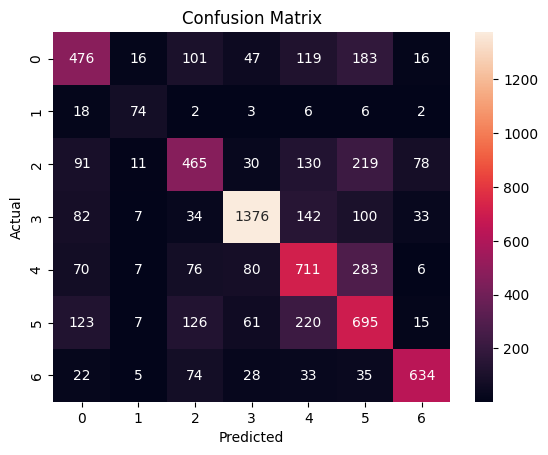

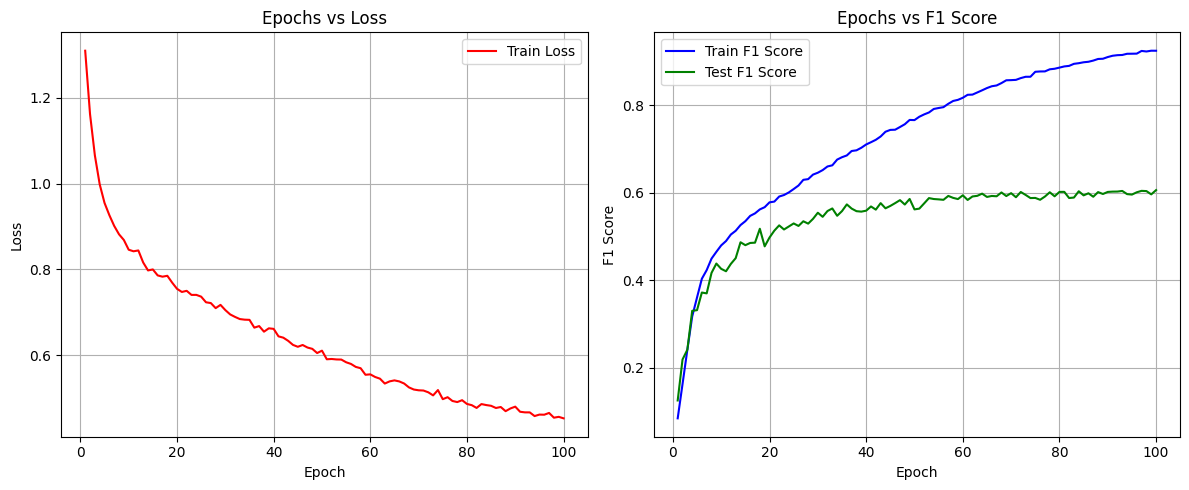

              precision    recall  f1-score   support

       angry       0.52      0.51      0.51       958
     disgust       0.54      0.68      0.60       111
        fear       0.48      0.48      0.48      1024
       happy       0.85      0.75      0.80      1774
     neutral       0.56      0.56      0.56      1233
         sad       0.46      0.55      0.50      1247
    surprise       0.83      0.74      0.79       831

    accuracy                           0.61      7178
   macro avg       0.60      0.61      0.61      7178
weighted avg       0.63      0.61      0.62      7178



In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from collections import Counter
import onnx
from sklearn.metrics import classification_report

# Transformations
train_transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = ImageFolder("archive/train", transform=train_transformation)
test_dataset = ImageFolder("archive/test", transform=test_transformation)

# Calculate sample weights for WeightedRandomSampler
class_names = train_dataset.classes
train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.dropout_conv = nn.Dropout2d(0.2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 7)
        self.LeakyReLU = nn.LeakyReLU()

    def forward(self, X):
        X = self.LeakyReLU(self.batch_norm1(self.conv1(X)))
        X = self.LeakyReLU(self.batch_norm2(self.conv2(X)))
        X = self.LeakyReLU(self.batch_norm3(self.conv3(X)))
        X = self.dropout_conv(X)
        X = self.pool1(X)
        X = self.pool2(X)
        X = X.view(X.size(0), -1)
        X = self.dropout1(self.LeakyReLU(self.fc1(X)))
        X = self.dropout2(self.LeakyReLU(self.fc2(X)))
        X = self.fc3(X)
        return X

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

def compute_numerical_gradient(model,X,y,epsilon = 1e-5):
    numerical_grad= {}
    for name,param in model.named_parameters():
      if param.requires_grad:
        original_param = param.data.clone()

        numerical_grad[name] = torch.zeros_like(param)
        param.data = original_param + epsilon
        loss_plus = criterion(model(X), y)
        param.data = original_param - epsilon
        loss_minus = criterion(model(X), y)
        numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
        numerical_grad[name] = numerical_grad.item()
        param.data = original_param
        print(f"Name: {name}")
        print(f"Backprop Gradient: {param.grad.data[:5]}")
        print(f"Numerical Gradient: {numerical_grad[name]}")
    return numerical_grad

# Updated class weights
samples_per_class = [4958, 547, 5121, 8989, 6077, 4002, 6198]
total_samples = sum(samples_per_class)
num_classes = len(samples_per_class)
calculated_weights = [total_samples / (num_classes * count) for count in samples_per_class]
class_weights_tensor = torch.tensor(calculated_weights, dtype=torch.float).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
num_epoch = 100

# Training
for epoch in range(1, num_epoch + 1):
    train_prediction = []
    train_actual = []
    model.train()
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device).long()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        epoch_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        train_prediction.extend(pred.cpu().numpy())
        train_actual.extend(y.cpu().numpy())

    print(f"Epoch {epoch}/{num_epoch}: Loss --> {epoch_loss / len(train_loader):.4f}")
    print(f"Train Accuracy: {accuracy_score(train_actual, train_prediction):.4f}")
    print(f"Train Precision: {precision_score(train_actual, train_prediction, average='micro'):.4f}")
    print(f"Train Recall: {recall_score(train_actual, train_prediction, average='micro'):.4f}")
    print(f"Train F1 Score: {f1_score(train_actual, train_prediction, average='macro'):.4f}")

# Evaluation
model.eval()
test_actual = []
test_prediction = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        test_prediction.extend(pred.cpu().numpy())
        test_actual.extend(y.cpu().numpy())

print(f"Test Accuracy: {accuracy_score(test_actual, test_prediction):.4f}")
print(f"Test Precision: {precision_score(test_actual, test_prediction, average='micro'):.4f}")
print(f"Test Recall: {recall_score(test_actual, test_prediction, average='micro'):.4f}")
print(f"Test F1 Score: {f1_score(test_actual, test_prediction, average='micro'):.4f}")

# Confusion matrix
cm = confusion_matrix(test_actual, test_prediction)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Export model
torch.save(model.state_dict(), "emotion_model.pth")
dummy_input = torch.randn(1, 1, 48, 48).to(device)
torch.onnx.export(model, dummy_input, "emotion_model.onnx", input_names=["input"], output_names=["output"])

train_f1_scores = []
train_losses = []
test_f1_scores = []

# Re-run training loop to capture F1 and loss history
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(1, num_epoch + 1):
    model.train()
    epoch_loss = 0
    train_actual = []
    train_prediction = []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device).long()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        epoch_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        train_prediction.extend(pred.cpu().numpy())
        train_actual.extend(y.cpu().numpy())

    train_f1 = f1_score(train_actual, train_prediction, average='macro')
    train_f1_scores.append(train_f1)
    train_losses.append(epoch_loss / len(train_loader))

    # Test F1 for each epoch
    model.eval()
    test_prediction = []
    test_actual = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            pred = torch.argmax(output, dim=1)
            test_prediction.extend(pred.cpu().numpy())
            test_actual.extend(y.cpu().numpy())
    test_f1 = f1_score(test_actual, test_prediction, average='macro')
    test_f1_scores.append(test_f1)

# Plotting F1 Score and Loss
epochs = list(range(1, num_epoch + 1))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1_scores, label="Train F1 Score", color='blue')
plt.plot(epochs, test_f1_scores, label="Test F1 Score", color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Epochs vs F1 Score")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
print(classification_report(test_actual, test_prediction, target_names=class_names))